In [1]:
! pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
You should consider upgrading via the 'pip install --upgrade pip' command.


In [21]:
! pip install easydict jamo tqdm pillow lmdb natsort nltk adabound

ValueError: filedescriptor out of range in select()

In [1]:
import json
import PIL as pil
import pandas as pd
import os
import sys
import random
import torch
import torch.backends.cudnn as cudnn
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import easydict

import sys
import re
import six
import math
import torchvision.transforms as transforms

from utils import AttnLabelConverter, Averager, AlignCollate
import utils
import Trans
import Extract
from Seq import BidirectionalLSTM
import Seq
import Pred
import torch.nn as nn
from torch.utils.data import *
from jamo import h2j, j2hcj
import gc
import adabound
import torch.distributed as dist
# from apex.parallel import DistributedDataParallel as DDP

def json_loader(path):
    with open(path, 'r') as json_file:
        file = json.load(json_file)
    return file

def img_annot_split(label):
    label_images = pd.DataFrame(label['images'])
    label_annot = pd.DataFrame(label['annotations'])
    return label_images, label_annot

In [2]:
import importlib
importlib.reload(Trans)

<module 'Trans' from '/Data/FoodDetection/AI_OCR/Trans.py'>

### arguements

In [3]:
# opt
opt = easydict.EasyDict({
    "experiment_name" : 'second_0527',
    "manualSeed" : 1111,
    "imgH" : 35 ,
    "imgW" :  90,
    "PAD" : True ,
    'batch_size' : 384,
    'data_filtering_off' : True,
    'workers' : 20,
    'rgb' :True,
    'sensitive' : True,
    'character' : '0123456789ㄱㄲㄴㄷㄸㄹㅁㅂㅃㅅㅆㅇㅈㅉㅊㅋㅌㅍㅎㄵㄶㄺㄻㅀㄼㅄㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣㅐㅒㅔㅖㅢㅟㅝㅞㅚㅘㅙ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' ,
    'batch_max_length' : 25,
    'num_fiducial' : 20,
    'output_channel' : 512,
    'hidden_size' :256,
    'lr' : 1,
    'rho' : 0.95,
    'eps' : 1e-8,
    'grad_clip' : 5,
    'valInterval' : 100,
    'num_epoch' : 30000,
    'input_channel' : 3,
    'saved_model' : 'second_0527/best_accuracy.pth',
    'FT' : True
    })

device = torch.device('cuda') #utils.py 안에 device는 따로 세팅해줘야함

### dataset

In [4]:
base_path = '/Data/KoreanSTR/'

# path_wild = '/Data/KoreanSTR/textinthewild_data_info.json'
# path_printed = '/Data/KoreanSTR/printed_data_info.json'
path_hand = '/Data/KoreanSTR/handwriting_data_info1.json'
# path_aug = '/Data/KoreanSTR/augmentation_data_info.json'

label_hand = json_loader(path_hand)
label_hand_images, label_hand_annot = img_annot_split(label_hand)

label_hand_annot = label_hand_annot[['id','text']]

dataset = '1_word'
file_list_word = os.listdir(os.path.join(base_path, dataset))
files_word = pd.DataFrame(file_list_word, columns=['file_name'])
files_word['id'] = files_word['file_name'].apply(lambda x : x.replace('.png',''))
files_labels = pd.merge(files_word, label_hand_annot, how='left', left_on='id',right_on='id' )

word_data = []
# random_idx = np.random.choice(range(len(files_labels)), size= int(len(files_labels) * 1), replace=False)
for file in tqdm(files_labels['file_name']):
#     img_arr = np.asarray(Image.open(os.path.join(base_path, dataset, file)))
    img_arr = Image.open(os.path.join(base_path, dataset, file))
    word_data.append(img_arr)
    
labels = [j2hcj(h2j(x)) for x in files_labels['text']]

dataset = []
for img, text in zip(word_data, labels):
    dataset.append((img, text))
    
random.shuffle(dataset)

100%|██████████| 359997/359997 [00:21<00:00, 16700.77it/s]


In [ ]:
from itertools import islice, cycle

class Dataset_streamer(Dataset):
    
    def __init__(self, dataset, transformer=None):
        self.dataset = dataset
        self.transformer = transformer

    def __len__(self):
        return len(self.dataset)
        
#     def __iter__(self):
#         return cycle(self.dataset)
    
    def __getitem__(self, idx):
        
        if self.transformer:
            return (self.transformer(self.dataset[idx][0]), self.dataset[idx][1])
        
        else:
            return self.dataset[idx]
                    
    
transform = transforms.Compose([transforms.ColorJitter(brightness=0.2, contrast=0.3),
                                transforms.RandomAffine(degrees= 50,shear=45),
                                transforms.RandomPerspective(distortion_scale=0.3, p=0.7, interpolation=3, fill=0)])

dataset_streamer = Dataset_streamer(dataset[ : int(len(dataset)*0.9)], transform)
valid_streamer = Dataset_streamer(dataset[int(len(dataset)*0.9) : ], transform)

In [ ]:
_AlignCollate = utils.AlignCollate(imgH=opt.imgH, imgW=opt.imgW, keep_ratio_with_pad=True)
data_loader = DataLoader(dataset_streamer, batch_size = opt.batch_size,  num_workers =0, shuffle=True, #worker_init_fn=worker_init_fn, 
                         collate_fn = _AlignCollate, pin_memory=False )
data_loader_iter = iter(data_loader)

#for valid
_AlignCollate_valid = utils.AlignCollate(imgH=opt.imgH, imgW=opt.imgW, keep_ratio_with_pad=True)
#not valid_streamer
valid_loader = DataLoader(valid_streamer, batch_size = opt.batch_size,  num_workers=0, shuffle=True, #worker_init_fn = worker_init_fn,
                          collate_fn=_AlignCollate_valid, pin_memory=False)

In [114]:
img, label = next(data_loader_iter)
# valid_iter = iter(valid_loader)
# img, label = valid_iter.next()

ㅎㅏㅁㄲㅔㅎㅏㄷㅏ


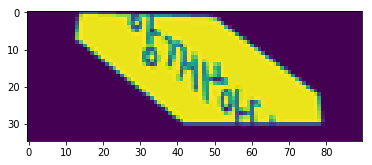

In [129]:
random_idx = np.random.choice(range(opt.batch_size),size=1)[0]
plt.imshow(img[random_idx].numpy()[0])
print(label[random_idx])

In [38]:
len(dataset)

359997

### model

In [ ]:
class CTN(nn.Module):
    def __init__(self, opt):
        super(CTN, self).__init__()
        self.opt = opt
        
        #Trans
        self.Trans = Trans.TPS_SpatialTransformerNetwork(F = opt.num_fiducial,
                                                  i_size = (opt.imgH, opt.imgW), 
                                                  i_r_size= (opt.imgH, opt.imgW), 
                                                  i_channel_num=opt.input_channel,
                                                        device = device)
        #Extract
        self.Extract = Extract.RCNN_extractor(opt.input_channel, opt.output_channel)
        self.FeatureExtraction_output = opt.output_channel # (imgH/16 -1 )* 512
        self.AdaptiveAvgPool = nn.AdaptiveAvgPool2d((None,1)) # imgH/16-1   ->  1
#         self.Extract = EfficientNet()
        
        
         
        # Sequence
        self.Seq = nn.Sequential(
            BidirectionalLSTM(self.FeatureExtraction_output, opt.hidden_size,  opt.hidden_size),
#             BidirectionalLSTM(1536, opt.hidden_size,  opt.hidden_size),
            BidirectionalLSTM(opt.hidden_size, opt.hidden_size, opt.hidden_size))
        self.Seq_output = opt.hidden_size
        
        #Pred
        self.Pred = Pred.Attention(self.Seq_output, opt.hidden_size, opt.num_class, device=device)
        
        
    def forward(self, input, text, is_train=True):
        #Trans stage
        input = self.Trans(input)
        
        #Extract stage
        visual_feature = self.Extract(input)
        visual_feature = self.AdaptiveAvgPool(visual_feature.permute(0, 3, 1, 2))
        visual_feature = visual_feature.squeeze(3)
        
        #Seq stage
        contextual_feature = self.Seq(visual_feature)
        #Pred stage
        prediction = self.Pred(contextual_feature.contiguous(), text, is_train, batch_max_length = self.opt.batch_max_length)

        return prediction

In [ ]:
def train(opt):
    converter = AttnLabelConverter(opt.character)
    opt.num_class = len(converter.character)
    
    model = CTN(opt)
    print('model parameters. height {}, width {}, num of fiducial {}, input channel {}, output channel {}, hidden size {}, num class {},\
    batch max length {}'.format(opt.imgH, opt.imgW, opt.num_fiducial, opt.input_channel, opt.output_channel, opt.hidden_size, opt.num_class,
                               opt.batch_max_length))
    
    # weight initialization
    for name, param, in model.named_parameters():
        if 'localization_fc2' in name:
            print(f'Skip {name} as it is already initializaed')
            continue
        try:
            if 'bias' in name:
                init.constant_(param, 0.0)
            elif 'weight' in name:
                init.kaiming_normal_(param)
                
        except Exception as e :
            if 'weight' in name:
                param.data.fill_(1)
            continue
            
    #data parallel for multi GPU
    model = torch.nn.DataParallel(model, device_ids = [0,1]).to(device)
#     model = model.to(device)
    model.train() 
    
    if opt.saved_model != '':
        base_path = './models'
        print(f'looking for pretrained model from {os.path.join(base_path, opt.saved_model)}')
        
        try :
            if opt.FT:
                model.load_state_dict(torch.load(os.path.join(base_path, opt.saved_model)), strict=False)
            else:
                model.load_state_dict(torch.load(os.path.join(base_path, opt.saved_model)))
            print('loading complete')    
        except Exception as e:
            print(e)
            print('coud not find model')
        
     
    # loss
    criterion = torch.nn.CrossEntropyLoss(ignore_index=0).to(device) #ignore [GO] token = ignore index 0
    log_avg = Averager()
    
    # filter that only require gradient descent
    filtered_parameters = []
    params_num = []
    for p in filter(lambda p : p.requires_grad, model.parameters()):
        filtered_parameters.append(p)
        params_num.append(np.prod(p.size()))
    print('Tranable params : ', sum(params_num))
    
    # optimizer
    optimizer = optim.Adadelta(filtered_parameters, lr= opt.lr, rho = opt.rho, eps = opt.eps)
#     optimizer = adabound.AdaBound(filtered_parameters, lr=1e-3, final_lr=0.1)
    
    # opt log
    with open(f'./models/{opt.experiment_name}/opt.txt', 'a') as opt_file:
        opt_log = '---------------------Options-----------------\n'
        args = vars(opt)
        for k, v in args.items():
            opt_log +=f'{str(k)} : {str(v)}\n'
        opt_log +='---------------------------------------------\n'
        opt_file.write(opt_log)
        
    #start training
    start_iter = 0
    
    start_time = time.time()
    best_accuracy = -1
    best_norm_ED = -1

    
    
    for n_epoch, epoch in enumerate(range(opt.num_epoch)):
        for n_iter, data_point in enumerate(data_loader):
            image_tensors, labels = data_point
            
            
#     while(True):
#         image_tensors, labels = data_loader_iter.next()
            image = image_tensors.to(device)
            text, length = converter.encode(labels, batch_max_length = opt.batch_max_length)

            batch_size = image.size(0)


            preds = model(image, text[:, : -1])
            target = text[:, 1:]
            cost = criterion(preds.view(-1, preds.shape[-1]), target.contiguous().view(-1))

            loss_avg = Averager()

            model.zero_grad()
            cost.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), opt.grad_clip) #gradient clipping with 5
            optimizer.step()

            loss_avg.add(cost)

            #validation
            if n_iter % opt.valInterval == 0:
                elapsed_time = time.time() - start_time
                with open(f'./models/{opt.experiment_name}/log_train.txt', 'a') as log:
                    model.eval()
                    with torch.no_grad():
                        valid_loss, current_accuracy, current_norm_ED, preds, confidence_score, labels, infer_time, length_of_data = utils.validation(
                            model, criterion, valid_loader, converter, opt)
                    model.train()
                    
                    present_time = time.localtime()
                    loss_log = f'[epoch : {n_epoch}/{opt.num_epoch}] [iter : {n_iter*opt.batch_size} / {len(dataset)}]\n'+\
                    f'Train loss : {loss_avg.val():0.5f}, Valid loss : {valid_loss:0.5f}, Elapsed time : {elapsed_time:0.5f}, Present time : {present_time[1]}/{present_time[2]}, {present_time[3]+9} : {present_time[4]}'
                    loss_avg.reset()

                    current_model_log = f'{"Current_accuracy":17s}: {current_accuracy:0.3f}, {"current_norm_ED":17s}: {current_norm_ED:0.2f}'


                    #keep the best
                    if current_accuracy > best_accuracy:
                        best_accuracy = current_accuracy
                        torch.save(model.state_dict(), f'./models/{opt.experiment_name}/best_accuracy.pth')

                    if current_norm_ED > best_norm_ED:
                        best_norm_ED = current_norm_ED
                        torch.save(model.state_dict(), f'./models/{opt.experiment_name}/best_norm_ED.pth')

                    best_model_log = f'{"Best accuracy":17s}: {best_accuracy:0.3f}, {"Best_norm_ED":17s}: {best_norm_ED:0.2f}'
                    loss_model_log = f'{loss_log}\n{current_model_log}\n{best_model_log}'
                    print(loss_model_log)
                    log.write(loss_model_log+'\n')


                    dashed_line = '-'*80
                    head = f'{"Ground Truth":25s} | {"Prediction" :25s}| Confidence Score & T/F'
                    predicted_result_log = f'{dashed_line}\n{head}\n{dashed_line}\n'

                    random_idx  = np.random.choice(range(len(labels)), size= 5, replace=False)
                    for gt, pred, confidence in zip(list(np.asarray(labels)[random_idx]), list(np.asarray(preds)[random_idx]), list(np.asarray(confidence_score)[random_idx])):
    #                     if 'Attn' in opt.Prediction:
                        gt = gt[: gt.find('[s]')]
                        pred = pred[: pred.find('[s]')]

                        predicted_result_log += f'{gt:25s} | {pred:25s} | {confidence:0.4f}\t{str(pred == gt)}\n'
                    predicted_result_log += f'{dashed_line}'
                    print(predicted_result_log)
                    log.write(predicted_result_log+'\n')

            if (n_epoch)% 10 ==0:
                torch.save(model.state_dict(), f'./models/{opt.experiment_name}/{n_epoch}.pth')


In [ ]:
# def main():
os.makedirs(f'./models/{opt.experiment_name}', exist_ok=True)

# set seed
random.seed(opt.manualSeed)
np.random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)
torch.cuda.manual_seed(opt.manualSeed)

# set GPU
cudnn.benchmark = True
cudnn.deterministic = True
opt.num_gpu = torch.cuda.device_count()

if opt.num_gpu > 1:
    print('-------- Use multi GPU setting --------')
    opt.workers = opt.workers * opt.num_gpu
    opt.batch_size = opt.batch_size * opt.num_gpu

train(opt)

-------- Use multi GPU setting --------
model parameters. height 35, width 90, num of fiducial 20, input channel 3, output channel 512, hidden size 256, num class 91,    batch max length 25
Skip Trans.LocalizationNetwork.localization_fc2.weight as it is already initializaed
Skip Trans.LocalizationNetwork.localization_fc2.bias as it is already initializaed
looking for pretrained model from ./models/second_0527/best_accuracy.pth
loading complete
Tranable params :  7221443


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[epoch : 0/30000] [iter : 0 / 359997]
Train loss : 3.33227, Valid loss : 11.06066, Elapsed time : 8.89035, Present time : 5/27, 14 : 17
Current_accuracy : 1.028, current_norm_ED  : 0.20
Best accuracy    : 1.028, Best_norm_ED     : 0.20
--------------------------------------------------------------------------------
Ground Truth              | Prediction               | Confidence Score & T/F
--------------------------------------------------------------------------------
ㅁㅗㅇㅕㄷㅡㄹㄷㅏ                 | ㅁㅜㅇㅢㅁㅣㅅㅡ                  | 0.0255	False
ㅊㅏㄴㅁㅜㄹ                    | ㅇㅓㅂㄹㅕㄱㅎㅏㄷㅏ                | 0.1471	False
ㅅㅣㄱㅏㄱ                     | ㅇㅛㄱㅜㄷㅚㄷㅏ                  | 0.1883	False
ㅂㅐㅊㅣ                      | ㅇㅏㄴㅈㅓㄴㄷㅚㄷㅏ                | 0.0440	False
ㅈㅓㅇㅊㅣㅎㅏㄱ                  | ㅇㅗㅇㅕㅁㄷㅚㄷㅏ                 | 0.0405	False
--------------------------------------------------------------------------------
[epoch : 0/30000] [iter : 100 / 359997]
Train loss : 0.67628, Valid loss : 4.83427, Elapsed time :

[epoch : 1/30000] [iter : 100 / 359997]
Train loss : 0.18228, Valid loss : 2.06182, Elapsed time : 8248.57902, Present time : 5/27, 16 : 34
Current_accuracy : 65.686, current_norm_ED  : 0.82
Best accuracy    : 65.686, Best_norm_ED     : 0.82
--------------------------------------------------------------------------------
Ground Truth              | Prediction               | Confidence Score & T/F
--------------------------------------------------------------------------------
ㅇㅠㄱㄱㅜㄴ                    | ㅇㅠㄱㄱㅜㄴ                    | 0.9113	True
ㅂㅕㅇㅅㅣㄹ                    | ㅂㅕㅇㅅㅣㄹ                    | 0.9904	True
ㄱㅗㅇㅅㅣㄱ                    | ㄱㅗㅇㅅㅣㄱ                    | 0.9751	True
ㅂㅕㄹㅁㅕㅇ                    | ㅂㅕㄹㅁㅕㅇ                    | 0.9040	True
ㄱㅕㅇㅜ                      | ㄱㅕㅇㅜ                      | 0.9865	True
--------------------------------------------------------------------------------
[epoch : 1/30000] [iter : 200 / 359997]
Train loss : 0.18705, Valid loss : 1.98397, Elapsed time 

[epoch : 2/30000] [iter : 200 / 359997]
Train loss : 0.12138, Valid loss : 1.57966, Elapsed time : 16364.08370, Present time : 5/27, 18 : 49
Current_accuracy : 73.119, current_norm_ED  : 0.87
Best accuracy    : 73.903, Best_norm_ED     : 0.87
--------------------------------------------------------------------------------
Ground Truth              | Prediction               | Confidence Score & T/F
--------------------------------------------------------------------------------
ㅈㅣㄹㅡㅁㄱㅣㄹ                  | ㅈㅣㄹㅡㅁㄱㅣ                   | 0.2062	False
ㄷㅜㄹㅡㄷㅏ                    | ㄷㅜㄹㅡㄷㅏ                    | 0.8746	True
ㅈㅐㄷㅏ                      | ㅈㅐㄷㅏ                      | 0.9998	True
ㄴㅡㅇㄷㅗㅇㅈㅓㄱ                 | ㄴㅡㅇㄷㅗㅇㅈㅓㄱ                 | 0.9403	True
ㄱㅖㅅㅏㄴㅎㅏㄷㅏ                 | ㅅㅣㅁㅅㅣㅁㅎㅏㄷㅏ                | 0.0945	False
--------------------------------------------------------------------------------


----------------

In [17]:
converter = AttnLabelConverter(opt.character)
opt.num_class = len(converter.character)
model = CTN(opt).to(device)
model = torch.nn.DataParallel(model, device_ids = [0,1]).to(device)

In [12]:
text, length = converter.encode(label, batch_max_length = opt.batch_max_length)
img = img.to(device)
text = text.to(device)

In [13]:
output = model(img,text)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [13]:
# ext_output = model.Extract(trans_output)
# ext_output_ = ext_output.permute(0, 3,1,2).squeeze(3)
# seq_output = model.Seq(ext_output_)
# pred_output = model.Pred(seq_output, text)
# output.shape

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [18]:
torch.cuda.empty_cache() 